# Personality Analysis by Country
This notebook contains the code to perform personality analysis across countries. All data resides in the *data* folder, but due to the size restrictions these files are not present in the repo.

## Preprocessing

In [38]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import json
from helpers import *
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load all speakers from the parquet file
speakers = pd.read_parquet('data/speaker_attributes.parquet')

In [3]:
speakers.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


For this analysis, we would like select some number of speakers to represent their country. We will use the *nationality* column in our speakers data. Since this column contains an array of nationalities for each person, for simplicity we will choose the first one.

In [4]:
# Get nationalities (first one)
nationalities = speakers.nationality.apply(lambda nt: nt[0] if nt is not None else None)

In [5]:
# Find unique nationalities excluding None
unique_nat_qids = np.unique(nationalities[nationalities.values != None])

Let's see how many different nationalities we have in the dataset.

In [6]:
len(unique_nat_qids)

2704

We got 2704, but this is quite odd, as there are around 200 countries/nationalities in the world. Let's see what kind of nationalities are these. Since we only have QIDs for these nationalities, we will use the **wikidata** python library to get the wikidata information programmatically. We have put the helper functions as usual in the **helpers.py**

In [11]:
# Since loading these wikidata entities takes a long time, we will just look at a sample of 10
nationality_sample = []
for qid in unique_nat_qids[:10]:
    entity = get_wiki_entity(qid)
    nationality_sample.append(entity.label)

In [12]:
nationality_sample

[m'Gabon',
 m'Orkney Islands',
 m'United States of America',
 m'Sanada clan',
 m'Judaea',
 m'The Gambia',
 m'Canadian nationality law',
 m'Guinea',
 m'Guinea-Bissau',
 m'Pali kingdom']

Aha! We can see that there are some bogus nationality entries in our data like 'Canadian nationality law'. Seems like we need some pruning to identify the true countries. For this, we can check the wikidata attributes offline in WikiData and realize that the true countries are instance of an entity unsurprisingly called *country*. So, we will filter out nationalities based on this attribute next.

In [13]:
# Get all existing country entities
countries = get_countries(unique_nat_qids)

Let's check the number of countries now.

In [14]:
len(countries)

230

This seems about right. Let's check some sample of the countries to confirm.

In [16]:
[country.label for country in list(countries.values())[:10]]

[m'Gabon',
 m'The Gambia',
 m'Guinea',
 m'Guinea-Bissau',
 m"Côte d'Ivoire",
 m'Cameroon',
 m'Cape Verde',
 m'Lesotho',
 m'Liberia',
 m'Libya']

Great! Let's save these QIDs for later easy retrieval.

In [72]:
country_qids = list(countries.keys())
with open('data/country_qids.json', 'w') as f:
    f.write(json.dumps({'qids': country_qids}))

Next, we are going to identify the speakers for these countries. This next cell will take some time to run, so we will save its results as well once it is finished.

<font color='red'>WARNING: LONG EXECUTION!</font>

In [73]:
# Find speakers for those valid countries
country_speakers = speakers[speakers.nationality.apply(lambda nt: any([cid in nt for cid in country_qids]) if nt is not None else False)]

In [78]:
# Save for later easy retrieval
country_speakers.id.to_csv('data/country_speaker_qids.csv')

In [22]:
# Load data from saved files
country_speaker_qids = pd.read_csv('data/country_speaker_qids.csv')
country_speakers = speakers[speakers.id.isin(country_speaker_qids.id)]

with open('data/country_qids.json') as f:
    country_qids = json.load(f)['qids']

countries = {qid: get_wiki_entity(qid) for qid in country_qids}

Let's see how many people we have identified belonging to a valid country out of all speakers.

In [23]:
f"all={len(speakers)}, with_valid_country={len(country_speakers)}"

'all=9055981, with_valid_country=3164693'

Wow! We have pruned almost two thirds of the speakers. Let's who are some of these people who are not identified to belong to an existing country.

In [24]:
non_country_speakers = speakers[~speakers.id.isin(country_speaker_qids.id)]

In [27]:
non_country_speakers.head(15)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
7,"[Mikołaj Kopernik, Nikolaus Kopernikus, Copern...",[+1473-02-19T00:00:00Z],[Q1649871],[Q6581097],1394975677,[Q1026],None,"[Q11063, Q185351, Q188094, Q170790, Q16012028,...",None,None,Q619,Nicolaus Copernicus,None,item,[Q1841]
10,None,[+1606-06-06T00:00:00Z],[Q70972],[Q6581097],1395437957,[Q121842],None,"[Q214917, Q49757, Q333634, Q36180, Q1209498]",None,None,Q747,Pierre Corneille,None,item,[Q1841]
13,"[Platon, Aristocles]","[-0427-05-07T00:00:00Z, -0429-05-21T00:00:00Z]",[Q844930],[Q6581097],1393026075,[Q539051],None,"[Q4964182, Q26237228, Q49757]",None,None,Q859,Plato,None,item,None
16,[Andrei D. Sakharov],[+1921-05-21T00:00:00Z],"[Q15180, Q2305208]",[Q6581097],1373398920,[Q49542],None,"[Q169470, Q1476215, Q16742096]",None,[Q17281097],Q997,Andrei Sakharov,None,item,[Q7066]
17,None,"[+1896-06-06T00:00:00Z, +1896-01-01T00:00:00Z]",[Q172579],[Q6581097],1388733064,None,None,"[Q47064, Q82955, Q2095549]",[Q139596],[Q1054679],Q1056,Italo Balbo,None,item,None
29,[Marcus Salvius Otho],[+0032-04-28T00:00:00Z],[Q1747689],[Q6581097],1372905634,None,None,[Q82955],None,None,Q1416,Otho,None,item,[Q337547]
30,"[Titus Flavius Vespasianus, Emperor of Rome Ti...","[+0041-00-00T00:00:00Z, +0040-12-30T00:00:00Z,...",[Q1747689],[Q6581097],1394376651,None,None,"[Q82955, Q47064]",None,None,Q1421,Titus,None,item,[Q337547]
32,"[Ramesses, Pa-ra-mes-su, Menpehtyre, Rameses]",[-1300-00-00T00:00:00Z],[Q11768],[Q6581097],1388567331,None,None,[Q2304859],None,None,Q1526,Ramesses I,None,item,None
40,"[Emperor of Rome Gordianus III, Emperor of Rom...",[+0225-01-20T00:00:00Z],[Q1747689],[Q6581097],1382333078,None,None,[Q82955],None,None,Q1812,Gordian III,None,item,[Q337547]
61,"[Franciszek Karpinski, Franciszek Karpiński]",[+1741-10-04T00:00:00Z],[Q172107],[Q6581097],1387626215,[Q1026],None,"[Q49757, Q333634, Q214917, Q36180, Q182436]",None,None,Q3547,Franciszek Karpiński,None,item,None


Interesting. Seems like we have a lot of speakers from ancient times or simply not identified people (None). Before moving onto our analysis, let's visualize which countries are most represented. For this, we will need to get some more info on the country entities from the wikidata such as 3-letter ISO code so that we can use it later for visualization and to possibly merge external geolocation data.

In [28]:
# We will save this data for later retrieval as well
country_info = {qid: get_country_info(qid) for qid in country_qids}
with open('data/country_info.json', 'w') as f:
    json.dump(country_info, f)

In [29]:
# Load saved file
with open('data/country_info.json') as f:
    country_info = json.load(f)

In [30]:
list(country_info.items())[:5]

[('Q1000', {'name': 'Gabon', 'iso': 'GAB'}),
 ('Q1005', {'name': 'The Gambia', 'iso': 'GMB'}),
 ('Q1006', {'name': 'Guinea', 'iso': 'GIN'}),
 ('Q1007', {'name': 'Guinea-Bissau', 'iso': 'GNB'}),
 ('Q1008', {'name': "Côte d'Ivoire", 'iso': 'CIV'})]

We will create a new column on the **country_speakers** called *country* from first entries in the *nationality* column.

In [32]:
country_speakers = country_speakers.copy()
country_speakers['country'] = country_speakers.nationality.apply(lambda n: n[0])

Then we group by this new column and append the country info like name and ISO code from the *country_info* data.

In [34]:
country_speakers_grouped = country_speakers.groupby('country').agg({'id': 'count'})

In [35]:
country_speakers_grouped.head()

,id
country,
Q1000,371
Q100166,1
Q1005,727
Q1006,621
Q1007,222


In [36]:
country_speakers_grouped['country_name'] = country_speakers_grouped.index.map(lambda cid: country_info[cid]['name'] if cid in country_info else None)
country_speakers_grouped['country_iso'] = country_speakers_grouped.index.map(lambda cid: country_info[cid]['iso'] if cid in country_info else None)

In [37]:
country_speakers_grouped.head()

,id,country_name,country_iso
country,,,
Q1000,371,Gabon,GAB
Q100166,1,None,None
Q1005,727,The Gambia,GMB
Q1006,621,Guinea,GIN
Q1007,222,Guinea-Bissau,GNB


Let's finally visualize it using an interactive map.

In [61]:
fig = visualize_world(country_speakers_grouped, location_col='country_iso', color_col='id', hover_cols=['country_name'], title='Number of speakers', labels={'id': 'speakers'}, color_scale=px.colors.sequential.Turbo)
fig.write_html("static/world-speakers.html")

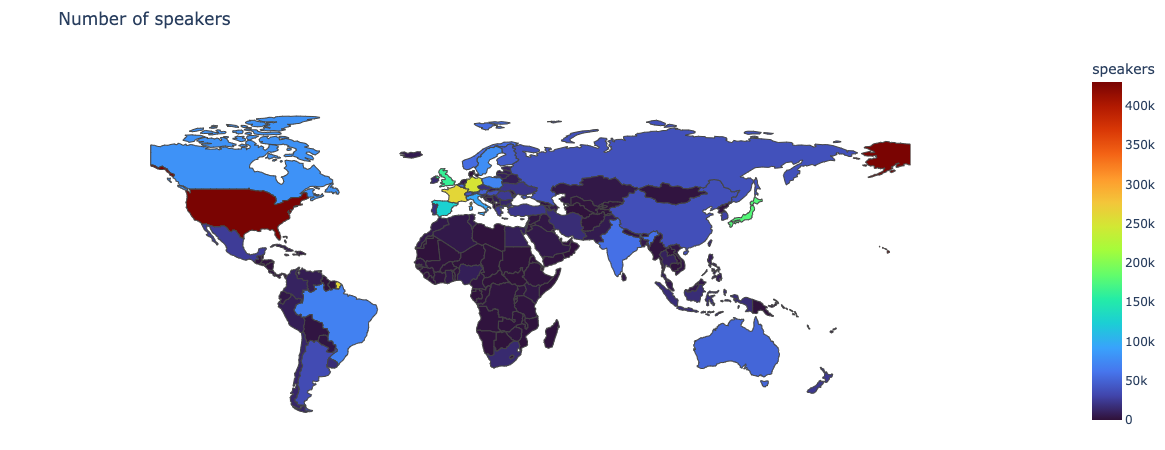

In [457]:
# Since the plotly doesnt load in github, here will load the saved image
from IPython.display import Image
Image(filename='static/world-speakers.png') 

We can clearly see that US is the most represented country while the whole continent of Africa is almost not represented and most of Latin American countries except Brazil and Argentina, Middle Asia and Middle East are amongst the underrepresented countries.

Now, we will proceed with our similar preprocessing to get the speakers with significant number of quotes.

In [62]:
with open('data/signi-quote-count-combined_1636253317430.json') as f:
    signi_quote_count_dict = json.load(f)

In [63]:
signi_quote_count_df = pd.Series(signi_quote_count_dict, name='signi_quote_count')

In [64]:
# Merge these country speakers with speakers who have significant number of quotes
signi_country_speakers = country_speakers.merge(signi_quote_count_df, left_on='id', right_index=True, how='inner')

In [65]:
len(signi_country_speakers)

436152

This reduced our number of speakers from 3mln to around 450k.

In [69]:
signi_country_speakers.country.nunique()

330

Seems like we still have some countries that might not be a valid country. Let's remove those rows.

In [70]:
signi_country_speakers = signi_country_speakers[signi_country_speakers.country.isin(country_qids)].copy()

In [71]:
signi_country_speakers.country.nunique()

218

Much better. Let's move on to select certain number of speakers per country to represent it. We will do some more analysis on the underrepresented countries before moving onto selecting speakers.

In [72]:
# Speakers grouped by country
speakers_by_country = signi_country_speakers.groupby('country')

In [73]:
speakers_by_country.size()

country
Q1000     35
Q1005    113
Q1006     91
Q1007     24
Q1008    174
        ... 
Q971      48
Q974     179
Q977      11
Q983      12
Q986      49
Length: 218, dtype: int64

In [90]:
speakers_by_country.size().min(), speakers_by_country.size().median(), speakers_by_country.size().max()

(1, 174.5, 146354)

In [77]:
speakers_by_country.count().sort_values(by=['id'], ascending=False)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,signi_quote_count
country,,,,,,,,,,,,,,,,
Q30,33018,132911,146354,146212,146354,9632,1488,143738,15662,1264,146354,146354,157,146354,4568,146354
Q145,11708,45758,48253,48172,48253,481,0,47502,2617,268,48253,48253,1678,48253,1127,48253
Q16,3359,21193,23965,23941,23965,218,0,23024,3106,119,23965,23965,800,23965,397,23965
Q408,3883,16570,18272,18239,18272,123,0,17969,2100,64,18272,18272,388,18272,318,18272
Q183,1741,16754,17033,17032,17033,100,0,16671,2600,1327,17033,17033,461,17033,694,17033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q2444884,1,2,2,2,2,1,0,2,0,0,2,2,0,2,1,2
Q25279,1,2,2,2,2,0,0,2,1,0,2,2,0,2,0,2
Q12060881,0,1,1,1,1,0,0,1,0,0,1,1,0,1,0,1


Let's now compare by quote count.

In [78]:
country_agg = speakers_by_country.agg({'id': 'count', 'signi_quote_count': 'sum'})

In [79]:
# Number of countries who have less than 10 speakers in the dataset
(country_agg.id < 10).sum()

20

In [80]:
# Number of countries who have less than 10 quotes
(country_agg.signi_quote_count < 10).sum()

6

In [81]:
# Let's see who are these underrepresented countries by speaker count
underrep_countries = list(country_agg[country_agg.id < 10].index)
[countries[c].label for c in underrep_countries]

[m'Imperial China',
 m'Northern Mariana Islands',
 m'South Vietnam',
 m'Aruba',
 m'Vatican City',
 m'Republic of Artsakh',
 m'Tibet',
 m'Curaçao',
 m'Cook Islands',
 m'Irish Free State',
 m'Niue',
 m'Somaliland',
 m'Sahrawi Arab Democratic Republic',
 m'German Empire',
 m'Zaire',
 m'Federated States of Micronesia',
 m'Danish Realm',
 m'Republic of Upper Volta',
 m'Turkmenistan',
 m'Transnistria']

In [82]:
# Now by quote count
underrep_countries_by_quote = list(country_agg[country_agg.signi_quote_count < 10].index)
[countries[c].label for c in underrep_countries_by_quote]

[m'Imperial China',
 m'Republic of Artsakh',
 m'Zaire',
 m'Republic of Upper Volta',
 m'Turkmenistan',
 m'Transnistria']

In [83]:
country_agg[country_agg.index.isin(underrep_countries)]

,id,signi_quote_count
country,,
Q12060881,1,1
Q16644,7,394
Q180573,2,10
Q21203,5,39
Q237,2,37501
Q244165,1,1
Q2444884,2,24
Q25279,2,18
Q26988,8,172


Here we see the quote count for speakerwise underrepresented countries. Most of the those countries also have relatively small number of quotes, however, there is one extreme outlier which has 37501 quotes. Let's see who this country is.

In [84]:
country_info['Q237']

{'name': 'Vatican City', 'iso': 'VAT'}

Right, this makes sense now. There is only one person, The Pope who is quoted from Vatican City, but he has been quoted quite many times. Enough fun with the data, let's move on to some more serious stuff. We will select top 100 speakers for each country, although as we have seen some countries dont have that many. Also for simplicity we will not account for other attributes like gender, ethnicity etc. as we dont have that many speakers for each country anyways and top speakers from each country usually are either politicians or other celebrities that are the face of the country to the world. So, what we will really be analysing is how each country is seen from other countries in terms of personality.

In [91]:
def select_top_speakers(speaker_group, top_k=100):
    speaker_group = speaker_group.sort_values(by=['signi_quote_count'], ascending=False)
    return speaker_group.iloc[:top_k]

selected_country_speakers = speakers_by_country.apply(select_top_speakers).reset_index(drop=True)

In [93]:
selected_country_speakers.sort_values(by=['signi_quote_count'], ascending=False).head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,country,signi_quote_count
6792,"[Donald John Trump, Donald J. Trump, Trump, Th...",[+1946-06-14T00:00:00Z],[Q30],[Q6581097],1395141850,None,None,"[Q911554, Q557880, Q3427922, Q15980158, Q13152...","[Q29468, Q1897793, Q29552, Q29468, Q29468]",[Q787674],Q22686,Donald Trump,"[Q699872, Q22923830, Q38051523]",item,[Q178169],Q30,201293
9292,"[Namo, Modi, Narendra Bhai, Narendra Damodarda...",[+1950-09-17T00:00:00Z],[Q668],[Q6581097],1395415052,"[Q1282294, Q6889284]",None,"[Q82955, Q36180, Q7019111, Q10429346]",[Q10230],None,Q1058,Narendra Modi,"[Q63988227, Q63988919, Q16841231, Q16251961, Q...",item,[Q9089],Q668,76404
6793,"[Barack Hussein Obama II, Barack Obama II, Bar...",[+1961-08-04T00:00:00Z],[Q30],[Q6581097],1395141963,"[Q49085, Q6935055, Q12826303, Q6392846]",O000167,"[Q82955, Q40348, Q15958642, Q28532974, Q372436]",[Q29552],"[Q1765120, Q1540185]",Q76,Barack Obama,"[Q3586671, Q45578, Q4226, Q4791768, Q17067714,...",item,"[Q23540, Q1062789, Q960252, Q426316]",Q30,59650
5484,"[Jorge Mario Bergoglio, Francisco, Pope Franci...",[+1936-12-17T00:00:00Z],"[Q237, Q414]",[Q6581097],1396054797,[Q1056744],None,"[Q63173086, Q593644, Q104050302, Q36180, Q1234...",None,[Q1233889],Q450675,Francis,None,item,[Q9592],Q237,37218
3076,"[Jürgen Norbert Klopp, Jurgen Klopp, Juergen K...",[+1967-06-16T00:00:00Z],[Q183],[Q6581097],1389758184,None,None,"[Q937857, Q628099]",None,None,Q83106,Jürgen Klopp,None,item,[Q75809],Q183,33025


In [94]:
# Let's save it for later retrieval
selected_country_speakers.to_parquet('data/rep100_country_speakers.parquet')

<font color='red'>WARNING: LONG EXECUTION!</font>

In [95]:
from functools import partial

years = [2015, 2016, 2017, 2018, 2019, 2020]
speaker_qids = selected_country_speakers.id.to_list() 
output_list = []

for year in years:
    path_to_input = PATTERN_INPUT.format(year)
    
    # Process quote file
    output_name = process_compressed_json_file(path_to_input, 'data/country-speaker-quotes100', year, partial(check_if_speaker_quote, speakers=speaker_qids))
    
    output_list.append(output_name)

print('\n\nOutput file names:')
for file_name in output_list:
    print(file_name)

Processing year 2015: 3189it [1:36:17,  1.81s/it]



File data/quotebank/quotes-2015.json.bz2 processed in 5781.2s



Processing year 2016: 2217it [57:30,  1.56s/it]



File data/quotebank/quotes-2016.json.bz2 processed in 3453.1s



Processing year 2017: 4962it [1:51:51,  1.35s/it]



File data/quotebank/quotes-2017.json.bz2 processed in 6716.4s



Processing year 2018: 4589it [1:52:24,  1.47s/it]



File data/quotebank/quotes-2018.json.bz2 processed in 6748.5s



Processing year 2019: 3397it [1:42:00,  1.80s/it]



File data/quotebank/quotes-2019.json.bz2 processed in 6124.7s



Processing year 2020: 793it [24:54,  1.88s/it]



File data/quotebank/quotes-2020.json.bz2 processed in 1495.0s



Output file names:
data/country-speaker-quotes100-2015_1639628384529.json
data/country-speaker-quotes100-2016_1639631839805.json
data/country-speaker-quotes100-2017_1639638554365.json
data/country-speaker-quotes100-2018_1639645304232.json
data/country-speaker-quotes100-2019_1639651430362.json
data/country-speaker-quotes100-2020_1639652929040.json


After 8 hrs of processing we have produced a quote file per year. We are going to do some usual preprocessing on them before our analysis. Since we are dealing with countries, it would be nice to do a longitudinal analysis. For this purpose, from now on we will work with an array of DataFrames where each DataFrame corresponds to a particular year always starting from 2015 and ending at 2020.

In [98]:
output_list = ['data/country-speaker-quotes100-2015_1639628384529.json',
               'data/country-speaker-quotes100-2016_1639631839805.json',
               'data/country-speaker-quotes100-2017_1639638554365.json',
               'data/country-speaker-quotes100-2018_1639645304232.json',
               'data/country-speaker-quotes100-2019_1639651430362.json',
               'data/country-speaker-quotes100-2020_1639652929040.json']

In [113]:
country_speaker_quotes = [read_json(output) for output in output_list]

We are gonna then filter out the bogus quotes.

In [114]:
country_speaker_quotes = [filter_quotes(cspq)[0] for cspq in country_speaker_quotes]

Next we are gonna concatenate quotes for each speaker. We will set the max quote length to 10000.

In [115]:
country_speaker_quotes_concat = [concatenate_quotes(cspq, quote_length=10000) for cspq in country_speaker_quotes]

In [116]:
country_speaker_quotes = [pd.Series(cspq, name='quotations') for cspq in country_speaker_quotes_concat]

In [117]:
country_speaker_quotes[0].head()

Q1253         profound and continuing concernâ € for civili...
Q2376327      I've seen a lot. I just watch and watch and w...
Q7199798      We are for electricity in each and every vill...
Q29654671     Surveillance for poliovirus has improved cons...
Q13427287     The poultry industry is discussing how we can...
Name: quotations, dtype: object

In [118]:
# Load representative speakers
selected_country_speakers = pd.read_parquet('data/rep100_country_speakers.parquet')

In [119]:
selected_country_speakers.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,country,signi_quote_count
0,None,[+1996-09-19T00:00:00Z],[Q1000],[Q6581097],1367630304,None,None,[Q3665646],None,None,Q20880774,Chris Silva,None,item,None,Q1000,218
1,[Mario René Junior Lemina],[+1993-09-01T00:00:00Z],[Q1000],[Q6581097],1349199504,None,None,[Q937857],None,None,Q13780454,Mario Lemina,None,item,None,Q1000,104
2,None,[+1942-11-24T00:00:00Z],[Q1000],[Q6581097],1320314694,None,None,"[Q193391, Q82955]",[Q1762536],None,Q58286,Jean Ping,None,item,None,Q1000,88
3,None,[+1959-02-09T00:00:00Z],[Q1000],[Q6581097],1356040176,[Q810747],None,"[Q193391, Q82955, Q40348]",[Q1762536],None,Q57521,Ali Bongo Ondimba,"[Q22227440, Q3031394]",item,[Q432],Q1000,36
4,None,[+1986-01-30T00:00:00Z],[Q1000],[Q6581097],1367638687,None,None,"[Q19204627, Q19841381]",None,None,Q7361376,Rolly Lumbala,None,item,None,Q1000,26


Now we are going to merge our country speaker quotes data with the selected speakers to prepare for analysis

In [120]:
country_quotes = [selected_country_speakers.merge(cspq, left_on='id', right_index=True, how='inner') for cspq in country_speaker_quotes]

In [121]:
country_quotes[0].head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,country,signi_quote_count,quotations
0,None,[+1996-09-19T00:00:00Z],[Q1000],[Q6581097],1367630304,None,None,[Q3665646],None,None,Q20880774,Chris Silva,None,item,None,Q1000,218,"Since becoming a public company one year ago,..."
1,[Mario René Junior Lemina],[+1993-09-01T00:00:00Z],[Q1000],[Q6581097],1349199504,None,None,[Q937857],None,None,Q13780454,Mario Lemina,None,item,None,Q1000,104,brings physical strength to Juventus `central...
2,None,[+1942-11-24T00:00:00Z],[Q1000],[Q6581097],1320314694,None,None,"[Q193391, Q82955]",[Q1762536],None,Q58286,Jean Ping,None,item,None,Q1000,88,We did not say anything serious except the tr...
3,None,[+1959-02-09T00:00:00Z],[Q1000],[Q6581097],1356040176,[Q810747],None,"[Q193391, Q82955, Q40348]",[Q1762536],None,Q57521,Ali Bongo Ondimba,"[Q22227440, Q3031394]",item,[Q432],Q1000,36,We were delighted to be chosen as the host na...
4,None,[+1986-01-30T00:00:00Z],[Q1000],[Q6581097],1367638687,None,None,"[Q19204627, Q19841381]",None,None,Q7361376,Rolly Lumbala,None,item,None,Q1000,26,"Watching him grow over the years, just when y..."


We are going to write these quotes to a file for offline LIWC processing.

In [122]:
for i, cq in enumerate(country_quotes):
    cq[['id', 'quotations']].to_csv(f'data/country_quotes100_{2015+i}.csv', index=False)

## Personality Analysis

In [139]:
country_quotes_liwc = [pd.read_csv(f'data/country_quotes100_{2015+i}_liwc.csv') for i in range(6)]

In [140]:
country_quotes_liwc[0].head()

,A,B,WC,WPS,Sixltr,Dic,Pronoun,I,We,Self,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,Q20880774,"Since becoming a public company one year ago,...",411,22.83,25.30,66.42,9.49,2.68,3.16,5.84,...,8.27,0.0,0.00,0.00,0.0,0.97,0.0,0.73,0.0,0.73
1,Q13780454,brings physical strength to Juventus `central...,166,23.71,15.66,72.29,15.66,9.04,1.81,10.84,...,4.22,0.0,0.00,0.00,0.0,0.60,0.0,3.01,0.0,0.60
2,Q58286,We did not say anything serious except the tr...,32,16.00,21.88,87.50,21.88,0.00,12.50,12.50,...,6.25,0.0,0.00,3.12,0.0,0.00,0.0,3.12,0.0,0.00
3,Q57521,We were delighted to be chosen as the host na...,411,24.18,23.36,67.40,8.76,1.95,2.92,4.87,...,2.43,0.0,0.49,0.00,0.0,0.73,0.0,1.22,0.0,0.00
4,Q7361376,"Watching him grow over the years, just when y...",61,15.25,21.31,68.85,14.75,0.00,0.00,0.00,...,8.20,0.0,0.00,0.00,0.0,0.00,0.0,6.56,0.0,0.00


In [373]:
# Predict personality
country_personality_by_year = [predict_personality(cql) for cql in country_quotes_liwc]


In [374]:
country_personality_by_year[0].head()

,neuroticism,anxiety,hostility,depression,self_consciousness,immoderation,vulnerability,extraversion,friendliness,gregariousness,...,cooperation,modesty,sympathy,conscientiousness,self_efficacy,orderliness,dutifulness,achievement_striving,self_discipline,cautiousness
0,0.742246,0.670736,1.594222,-0.532646,0.819898,-0.432471,0.911807,1.979829,4.932964,4.834686,...,3.804049,1.221506,1.939638e+00,-0.341397,1.916964,1.073785,2.048684,0.429590,-0.463638,0.957231
1,1.851480,2.235034,2.576738,0.152739,1.381947,0.133521,2.065153,2.836347,4.169948,5.858243,...,3.347060,0.741395,2.052899e+00,-0.721307,1.544998,1.637070,1.479108,-0.314852,-0.827575,0.762087
2,1.808717,1.823402,2.985127,0.925727,-2.413395,0.352584,0.602560,5.266027,5.868540,10.016238,...,-1.499953,1.514544,-6.938894e-18,-2.823779,0.014685,0.500424,0.456086,-2.250588,-2.176880,-1.691283
3,-0.804748,-0.647020,0.510958,-1.747883,-1.448697,-1.055537,-0.519675,2.932343,5.942803,5.113399,...,3.897642,1.566246,2.152001e+00,0.846173,3.330483,1.043334,2.030965,0.385356,0.559771,1.169268
4,-0.770521,-0.468869,1.052351,-0.468869,-1.989136,0.052097,-1.104447,4.311690,6.436912,7.332084,...,1.375349,1.031512,6.147395e-01,-0.593901,1.260737,0.145870,1.114867,-1.281576,-0.125032,0.083355


In [375]:
# Match personality and LIWC data
for i, cq in enumerate(country_quotes_liwc):
    country_personality_by_year[i].set_index(cq.A, inplace=True)

In [376]:
country_personality_by_year[0].head()

,neuroticism,anxiety,hostility,depression,self_consciousness,immoderation,vulnerability,extraversion,friendliness,gregariousness,...,cooperation,modesty,sympathy,conscientiousness,self_efficacy,orderliness,dutifulness,achievement_striving,self_discipline,cautiousness
A,,,,,,,,,,,,,,,,,,,,,
Q20880774,0.742246,0.670736,1.594222,-0.532646,0.819898,-0.432471,0.911807,1.979829,4.932964,4.834686,...,3.804049,1.221506,1.939638e+00,-0.341397,1.916964,1.073785,2.048684,0.429590,-0.463638,0.957231
Q13780454,1.851480,2.235034,2.576738,0.152739,1.381947,0.133521,2.065153,2.836347,4.169948,5.858243,...,3.347060,0.741395,2.052899e+00,-0.721307,1.544998,1.637070,1.479108,-0.314852,-0.827575,0.762087
Q58286,1.808717,1.823402,2.985127,0.925727,-2.413395,0.352584,0.602560,5.266027,5.868540,10.016238,...,-1.499953,1.514544,-6.938894e-18,-2.823779,0.014685,0.500424,0.456086,-2.250588,-2.176880,-1.691283
Q57521,-0.804748,-0.647020,0.510958,-1.747883,-1.448697,-1.055537,-0.519675,2.932343,5.942803,5.113399,...,3.897642,1.566246,2.152001e+00,0.846173,3.330483,1.043334,2.030965,0.385356,0.559771,1.169268
Q7361376,-0.770521,-0.468869,1.052351,-0.468869,-1.989136,0.052097,-1.104447,4.311690,6.436912,7.332084,...,1.375349,1.031512,6.147395e-01,-0.593901,1.260737,0.145870,1.114867,-1.281576,-0.125032,0.083355


In [377]:
# Merge personality with speaker attributes data
country_personality_by_year = [cp.merge(country_quotes[i][['id', 'label', 'country']], left_index=True, right_on='id', how='inner')
                               for i, cp in enumerate(country_personality_by_year)]

In [378]:
country_personality_by_year[0].head()

,neuroticism,anxiety,hostility,depression,self_consciousness,immoderation,vulnerability,extraversion,friendliness,gregariousness,...,conscientiousness,self_efficacy,orderliness,dutifulness,achievement_striving,self_discipline,cautiousness,id,label,country
0,0.742246,0.670736,1.594222,-0.532646,0.819898,-0.432471,0.911807,1.979829,4.932964,4.834686,...,-0.341397,1.916964,1.073785,2.048684,0.429590,-0.463638,0.957231,Q20880774,Chris Silva,Q1000
1,1.851480,2.235034,2.576738,0.152739,1.381947,0.133521,2.065153,2.836347,4.169948,5.858243,...,-0.721307,1.544998,1.637070,1.479108,-0.314852,-0.827575,0.762087,Q13780454,Mario Lemina,Q1000
2,1.808717,1.823402,2.985127,0.925727,-2.413395,0.352584,0.602560,5.266027,5.868540,10.016238,...,-2.823779,0.014685,0.500424,0.456086,-2.250588,-2.176880,-1.691283,Q58286,Jean Ping,Q1000
3,-0.804748,-0.647020,0.510958,-1.747883,-1.448697,-1.055537,-0.519675,2.932343,5.942803,5.113399,...,0.846173,3.330483,1.043334,2.030965,0.385356,0.559771,1.169268,Q57521,Ali Bongo Ondimba,Q1000
4,-0.770521,-0.468869,1.052351,-0.468869,-1.989136,0.052097,-1.104447,4.311690,6.436912,7.332084,...,-0.593901,1.260737,0.145870,1.114867,-1.281576,-0.125032,0.083355,Q7361376,Rolly Lumbala,Q1000


Next we will concatenate these dataframes (and add a new column *year*) and normalize (min-max) personality scores into [0, 1] interval across all years.

In [379]:
country_personality = pd.concat(country_personality_by_year, keys=[2015, 2016, 2017, 2018, 2019, 2020], names=['year']).reset_index(level=1, drop=True)

In [380]:
country_personality

,neuroticism,anxiety,hostility,depression,self_consciousness,immoderation,vulnerability,extraversion,friendliness,gregariousness,...,conscientiousness,self_efficacy,orderliness,dutifulness,achievement_striving,self_discipline,cautiousness,id,label,country
year,,,,,,,,,,,,,,,,,,,,,
2015,0.742246,0.670736,1.594222,-0.532646,0.819898,-0.432471,0.911807,1.979829,4.932964,4.834686,...,-0.341397,1.916964,1.073785,2.048684,0.429590,-0.463638,0.957231,Q20880774,Chris Silva,Q1000
2015,1.851480,2.235034,2.576738,0.152739,1.381947,0.133521,2.065153,2.836347,4.169948,5.858243,...,-0.721307,1.544998,1.637070,1.479108,-0.314852,-0.827575,0.762087,Q13780454,Mario Lemina,Q1000
2015,1.808717,1.823402,2.985127,0.925727,-2.413395,0.352584,0.602560,5.266027,5.868540,10.016238,...,-2.823779,0.014685,0.500424,0.456086,-2.250588,-2.176880,-1.691283,Q58286,Jean Ping,Q1000
2015,-0.804748,-0.647020,0.510958,-1.747883,-1.448697,-1.055537,-0.519675,2.932343,5.942803,5.113399,...,0.846173,3.330483,1.043334,2.030965,0.385356,0.559771,1.169268,Q57521,Ali Bongo Ondimba,Q1000
2015,-0.770521,-0.468869,1.052351,-0.468869,-1.989136,0.052097,-1.104447,4.311690,6.436912,7.332084,...,-0.593901,1.260737,0.145870,1.114867,-1.281576,-0.125032,0.083355,Q7361376,Rolly Lumbala,Q1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,2.000629,1.758241,2.403875,0.499874,0.451246,0.774534,1.951812,3.402680,4.128397,5.741570,...,-1.983895,1.258493,1.871792,0.725717,-1.725528,-1.209738,-0.774534,Q288305,Eric Moussambani,Q983
2020,0.608192,2.137814,1.980289,-0.725251,-1.764893,-1.293691,1.196398,5.862681,7.352386,8.903366,...,-0.333224,1.725636,1.137539,1.705869,-0.411629,-0.588042,1.019272,Q24761111,Francisco Pascual Obama Asue,Q983
2020,1.000000,1.764706,1.941176,-1.294118,-0.588235,-1.294118,0.411765,3.941176,5.352941,6.235294,...,-0.176471,1.529412,1.529412,2.176471,0.000000,-0.705882,1.470588,Q17991814,Daniel Alexander,Q986


In [381]:
for attr in PERSONALITY_ATTRS:
    country_personality[attr] = (country_personality[attr] - country_personality[attr].min()) / \
                                (country_personality[attr].max() - country_personality[attr].min())

In [382]:
country_personality.head()

,neuroticism,anxiety,hostility,depression,self_consciousness,immoderation,vulnerability,extraversion,friendliness,gregariousness,...,conscientiousness,self_efficacy,orderliness,dutifulness,achievement_striving,self_discipline,cautiousness,id,label,country
year,,,,,,,,,,,,,,,,,,,,,
2015,0.510532,0.641182,0.415982,0.458694,0.416150,0.480342,0.699799,0.537686,0.516036,0.555592,...,0.640716,0.573729,0.403405,0.441947,0.554994,0.579261,0.456551,Q20880774,Chris Silva,Q1000
2015,0.558760,0.701347,0.455814,0.486110,0.437767,0.506069,0.747524,0.570629,0.487776,0.582886,...,0.626104,0.559423,0.429403,0.419164,0.526361,0.567888,0.448420,Q13780454,Mario Lemina,Q1000
2015,0.556901,0.685515,0.472370,0.517029,0.291792,0.516027,0.687003,0.664078,0.550687,0.693766,...,0.545239,0.500565,0.376943,0.378243,0.451908,0.525722,0.346197,Q58286,Jean Ping,Q1000
2015,0.443272,0.590499,0.372066,0.410085,0.328896,0.452021,0.640565,0.574321,0.553437,0.563024,...,0.686391,0.628096,0.402000,0.441239,0.553292,0.611243,0.465386,Q57521,Ali Bongo Ondimba,Q1000
2015,0.444760,0.597351,0.394014,0.461245,0.308110,0.502368,0.616368,0.627373,0.571737,0.622189,...,0.631004,0.548490,0.360579,0.404595,0.489178,0.589843,0.420140,Q7361376,Rolly Lumbala,Q1000


Let's group personalities by year and country.

In [383]:
country_personality_grouped = country_personality.groupby(['year', 'country']) \
                                                 .agg({'id': 'count',
                                                       'label': lambda ls: ','.join([l for l in ls if l]),
                                                       **{attr: 'mean' for attr in PERSONALITY_ATTRS}}).reset_index()

In [384]:
country_personality_grouped.head()

,year,country,id,label,neuroticism,anxiety,hostility,depression,self_consciousness,immoderation,...,cooperation,modesty,sympathy,conscientiousness,self_efficacy,orderliness,dutifulness,achievement_striving,self_discipline,cautiousness
0,2015,Q1000,15,"Chris Silva,Mario Lemina,Jean Ping,Ali Bongo O...",0.499198,0.641040,0.418586,0.459583,0.367103,0.481156,...,0.462361,0.098426,0.400308,0.631919,0.582580,0.391549,0.421164,0.514597,0.578150,0.436443
1,2015,Q1005,41,"Fatou Bensouda,Omar Khan,Yahya Jammeh,Christop...",0.512556,0.636626,0.427506,0.467160,0.403332,0.483621,...,0.464053,0.079230,0.399768,0.623320,0.576774,0.400009,0.424558,0.521134,0.569142,0.439513
2,2015,Q1006,38,"Robert Sarah,Boubacar Keita,Amadou Diallo,Cell...",0.535714,0.648271,0.443018,0.474923,0.408480,0.488572,...,0.455022,0.083860,0.394662,0.603996,0.567101,0.396220,0.416118,0.495424,0.556072,0.430867
3,2015,Q1007,8,"Domingos Simoes Pereira,Carlos Correia,Ciprian...",0.523217,0.646901,0.433718,0.462680,0.392508,0.488164,...,0.442492,0.082580,0.401147,0.631924,0.577685,0.414487,0.397148,0.525554,0.574116,0.441669
4,2015,Q1008,55,"Abdul Razak,Eric Bailly,Wilfried Bony,Kolo Tou...",0.517125,0.638464,0.428270,0.468123,0.409910,0.484050,...,0.465681,0.093446,0.396824,0.628666,0.575356,0.402567,0.425968,0.524391,0.570951,0.439677


In [409]:
country_personality_grouped.to_csv(f'data/country_personality100_grouped.csv')

Next we will add ISO code and country name for visualization purposes.

In [385]:
country_personality_grouped['country_iso'] = country_personality_grouped.country.apply(lambda cid: country_info[cid]['iso'])
country_personality_grouped['country_name'] = country_personality_grouped.country.map(lambda cid: country_info[cid]['name'])

In [386]:
country_personality_grouped.head()

,year,country,id,label,neuroticism,anxiety,hostility,depression,self_consciousness,immoderation,...,sympathy,conscientiousness,self_efficacy,orderliness,dutifulness,achievement_striving,self_discipline,cautiousness,country_iso,country_name
0,2015,Q1000,15,"Chris Silva,Mario Lemina,Jean Ping,Ali Bongo O...",0.499198,0.641040,0.418586,0.459583,0.367103,0.481156,...,0.400308,0.631919,0.582580,0.391549,0.421164,0.514597,0.578150,0.436443,GAB,Gabon
1,2015,Q1005,41,"Fatou Bensouda,Omar Khan,Yahya Jammeh,Christop...",0.512556,0.636626,0.427506,0.467160,0.403332,0.483621,...,0.399768,0.623320,0.576774,0.400009,0.424558,0.521134,0.569142,0.439513,GMB,The Gambia
2,2015,Q1006,38,"Robert Sarah,Boubacar Keita,Amadou Diallo,Cell...",0.535714,0.648271,0.443018,0.474923,0.408480,0.488572,...,0.394662,0.603996,0.567101,0.396220,0.416118,0.495424,0.556072,0.430867,GIN,Guinea
3,2015,Q1007,8,"Domingos Simoes Pereira,Carlos Correia,Ciprian...",0.523217,0.646901,0.433718,0.462680,0.392508,0.488164,...,0.401147,0.631924,0.577685,0.414487,0.397148,0.525554,0.574116,0.441669,GNB,Guinea-Bissau
4,2015,Q1008,55,"Abdul Razak,Eric Bailly,Wilfried Bony,Kolo Tou...",0.517125,0.638464,0.428270,0.468123,0.409910,0.484050,...,0.396824,0.628666,0.575356,0.402567,0.425968,0.524391,0.570951,0.439677,CIV,Côte d'Ivoire


In [387]:
country_personality_grouped.rename(columns={'id': 'num_speakers', 'label': 'speakers'}, inplace=True)

In [388]:
country_personality_grouped.head()

,year,country,num_speakers,speakers,neuroticism,anxiety,hostility,depression,self_consciousness,immoderation,...,sympathy,conscientiousness,self_efficacy,orderliness,dutifulness,achievement_striving,self_discipline,cautiousness,country_iso,country_name
0,2015,Q1000,15,"Chris Silva,Mario Lemina,Jean Ping,Ali Bongo O...",0.499198,0.641040,0.418586,0.459583,0.367103,0.481156,...,0.400308,0.631919,0.582580,0.391549,0.421164,0.514597,0.578150,0.436443,GAB,Gabon
1,2015,Q1005,41,"Fatou Bensouda,Omar Khan,Yahya Jammeh,Christop...",0.512556,0.636626,0.427506,0.467160,0.403332,0.483621,...,0.399768,0.623320,0.576774,0.400009,0.424558,0.521134,0.569142,0.439513,GMB,The Gambia
2,2015,Q1006,38,"Robert Sarah,Boubacar Keita,Amadou Diallo,Cell...",0.535714,0.648271,0.443018,0.474923,0.408480,0.488572,...,0.394662,0.603996,0.567101,0.396220,0.416118,0.495424,0.556072,0.430867,GIN,Guinea
3,2015,Q1007,8,"Domingos Simoes Pereira,Carlos Correia,Ciprian...",0.523217,0.646901,0.433718,0.462680,0.392508,0.488164,...,0.401147,0.631924,0.577685,0.414487,0.397148,0.525554,0.574116,0.441669,GNB,Guinea-Bissau
4,2015,Q1008,55,"Abdul Razak,Eric Bailly,Wilfried Bony,Kolo Tou...",0.517125,0.638464,0.428270,0.468123,0.409910,0.484050,...,0.396824,0.628666,0.575356,0.402567,0.425968,0.524391,0.570951,0.439677,CIV,Côte d'Ivoire


In [393]:
# Save visualizations for data story
for attr in PERSONALITY_ATTRS:
    fig = visualize_world(country_personality_grouped, location_col='country_iso', color_col=attr,
                          hover_cols=['country_name', 'num_speakers'], animation_col='year',
                          range_col=[country_personality_grouped[attr].min(), country_personality_grouped[attr].max()])
    fig.write_html(f"static/world-map-{attr}.html")

We saved all these graphs and will interactively visualize them in the data story. For a sample image, see below.

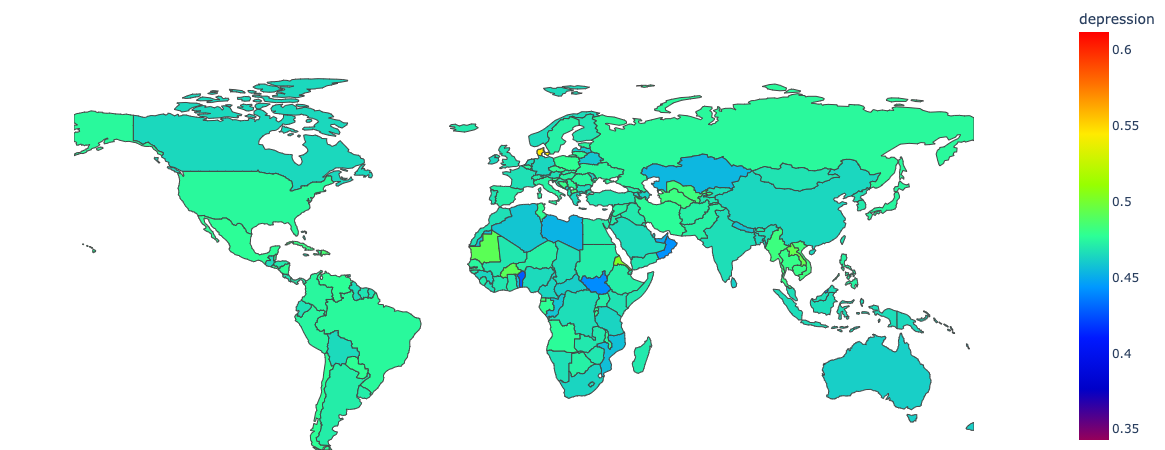

In [456]:
df = country_personality_grouped[country_personality_grouped.year == 2017]
color_col = 'depression'
fig = visualize_world(df, location_col='country_iso', color_col=color_col, 
                      range_col=[country_personality_grouped[color_col].min(),
                      country_personality_grouped[color_col].max()], 
                      hover_cols=['country_name', 'num_speakers'])
# Since the plotly doesnt load in github, here will load the saved image
from IPython.display import Image
Image(filename='static/depression-2017.png') 

## Democracy and Happiness index analysis

Now that we have some personality data on countries, it would be nice to compare this data to some interesting external data and see what we observe. We will use the data on Democracy and Happiness index of countries.

In [428]:
# This data was downloaded from https://www.gapminder.org/data/documentation/democracy-index/
democracy_index = pd.read_csv('data/democracy_index.csv')

In [429]:
democracy_index

,geo,name,time,Democracy index (EIU),Electoral pluralism index (EIU),Government index (EIU),Political participation index(EIU),Political culture index (EIU),Civil liberties index (EIU),Change in democracy index (EIU)
0,afg,Afghanistan,2006,30.6,61.70,0.00,22.2,25.0,44.10,NaN
1,afg,Afghanistan,2007,30.4,56.70,3.95,22.2,25.0,44.10,-0.2
2,afg,Afghanistan,2008,30.2,51.70,7.90,22.2,25.0,44.10,-0.2
3,afg,Afghanistan,2009,27.5,38.35,7.90,25.0,25.0,41.15,-2.7
4,afg,Afghanistan,2010,24.8,25.00,7.90,27.8,25.0,38.20,-2.7
...,...,...,...,...,...,...,...,...,...,...
2496,zwe,Zimbabwe,2016,30.5,5.00,20.00,38.9,56.3,32.40,NaN
2497,zwe,Zimbabwe,2017,31.6,5.00,20.00,44.4,56.3,32.40,NaN
2498,zwe,Zimbabwe,2018,31.6,5.00,20.00,44.4,56.3,32.40,NaN
2499,zwe,Zimbabwe,2019,31.6,0.00,25.00,44.4,56.3,32.40,NaN


In [434]:
democracy_index.geo = democracy_index.geo.str.upper()
democracy_index = democracy_index.reset_index(drop=True)

In [435]:
democracy_index.head()

,index,geo,name,time,Democracy index (EIU),Electoral pluralism index (EIU),Government index (EIU),Political participation index(EIU),Political culture index (EIU),Civil liberties index (EIU),Change in democracy index (EIU)
0,0,AFG,Afghanistan,2006,30.6,61.70,0.00,22.2,25.0,44.10,NaN
1,1,AFG,Afghanistan,2007,30.4,56.70,3.95,22.2,25.0,44.10,-0.2
2,2,AFG,Afghanistan,2008,30.2,51.70,7.90,22.2,25.0,44.10,-0.2
3,3,AFG,Afghanistan,2009,27.5,38.35,7.90,25.0,25.0,41.15,-2.7
4,4,AFG,Afghanistan,2010,24.8,25.00,7.90,27.8,25.0,38.20,-2.7


In [436]:
# Merge our data with democracy index data
country_personality_grouped_dem = country_personality_grouped.merge(democracy_index[["time", "geo", "Democracy index (EIU)"]], left_on=["country_iso", "year"], right_on=["geo", "time"], how='inner')

In [451]:
country_personality_grouped_dem.head()

,year,country,num_speakers,speakers,neuroticism,anxiety,hostility,depression,self_consciousness,immoderation,...,orderliness,dutifulness,achievement_striving,self_discipline,cautiousness,country_iso,country_name,time,geo,Democracy index (EIU)
0,2015,Q1000,15,"Chris Silva,Mario Lemina,Jean Ping,Ali Bongo O...",0.499198,0.641040,0.418586,0.459583,0.367103,0.481156,...,0.391549,0.421164,0.514597,0.578150,0.436443,GAB,Gabon,2015,GAB,37.6
1,2015,Q1005,41,"Fatou Bensouda,Omar Khan,Yahya Jammeh,Christop...",0.512556,0.636626,0.427506,0.467160,0.403332,0.483621,...,0.400009,0.424558,0.521134,0.569142,0.439513,GMB,The Gambia,2015,GMB,29.7
2,2015,Q1006,38,"Robert Sarah,Boubacar Keita,Amadou Diallo,Cell...",0.535714,0.648271,0.443018,0.474923,0.408480,0.488572,...,0.396220,0.416118,0.495424,0.556072,0.430867,GIN,Guinea,2015,GIN,31.4
3,2015,Q1007,8,"Domingos Simoes Pereira,Carlos Correia,Ciprian...",0.523217,0.646901,0.433718,0.462680,0.392508,0.488164,...,0.414487,0.397148,0.525554,0.574116,0.441669,GNB,Guinea-Bissau,2015,GNB,19.3
4,2015,Q1008,55,"Abdul Razak,Eric Bailly,Wilfried Bony,Kolo Tou...",0.517125,0.638464,0.428270,0.468123,0.409910,0.484050,...,0.402567,0.425968,0.524391,0.570951,0.439677,CIV,Côte d'Ivoire,2015,CIV,33.1


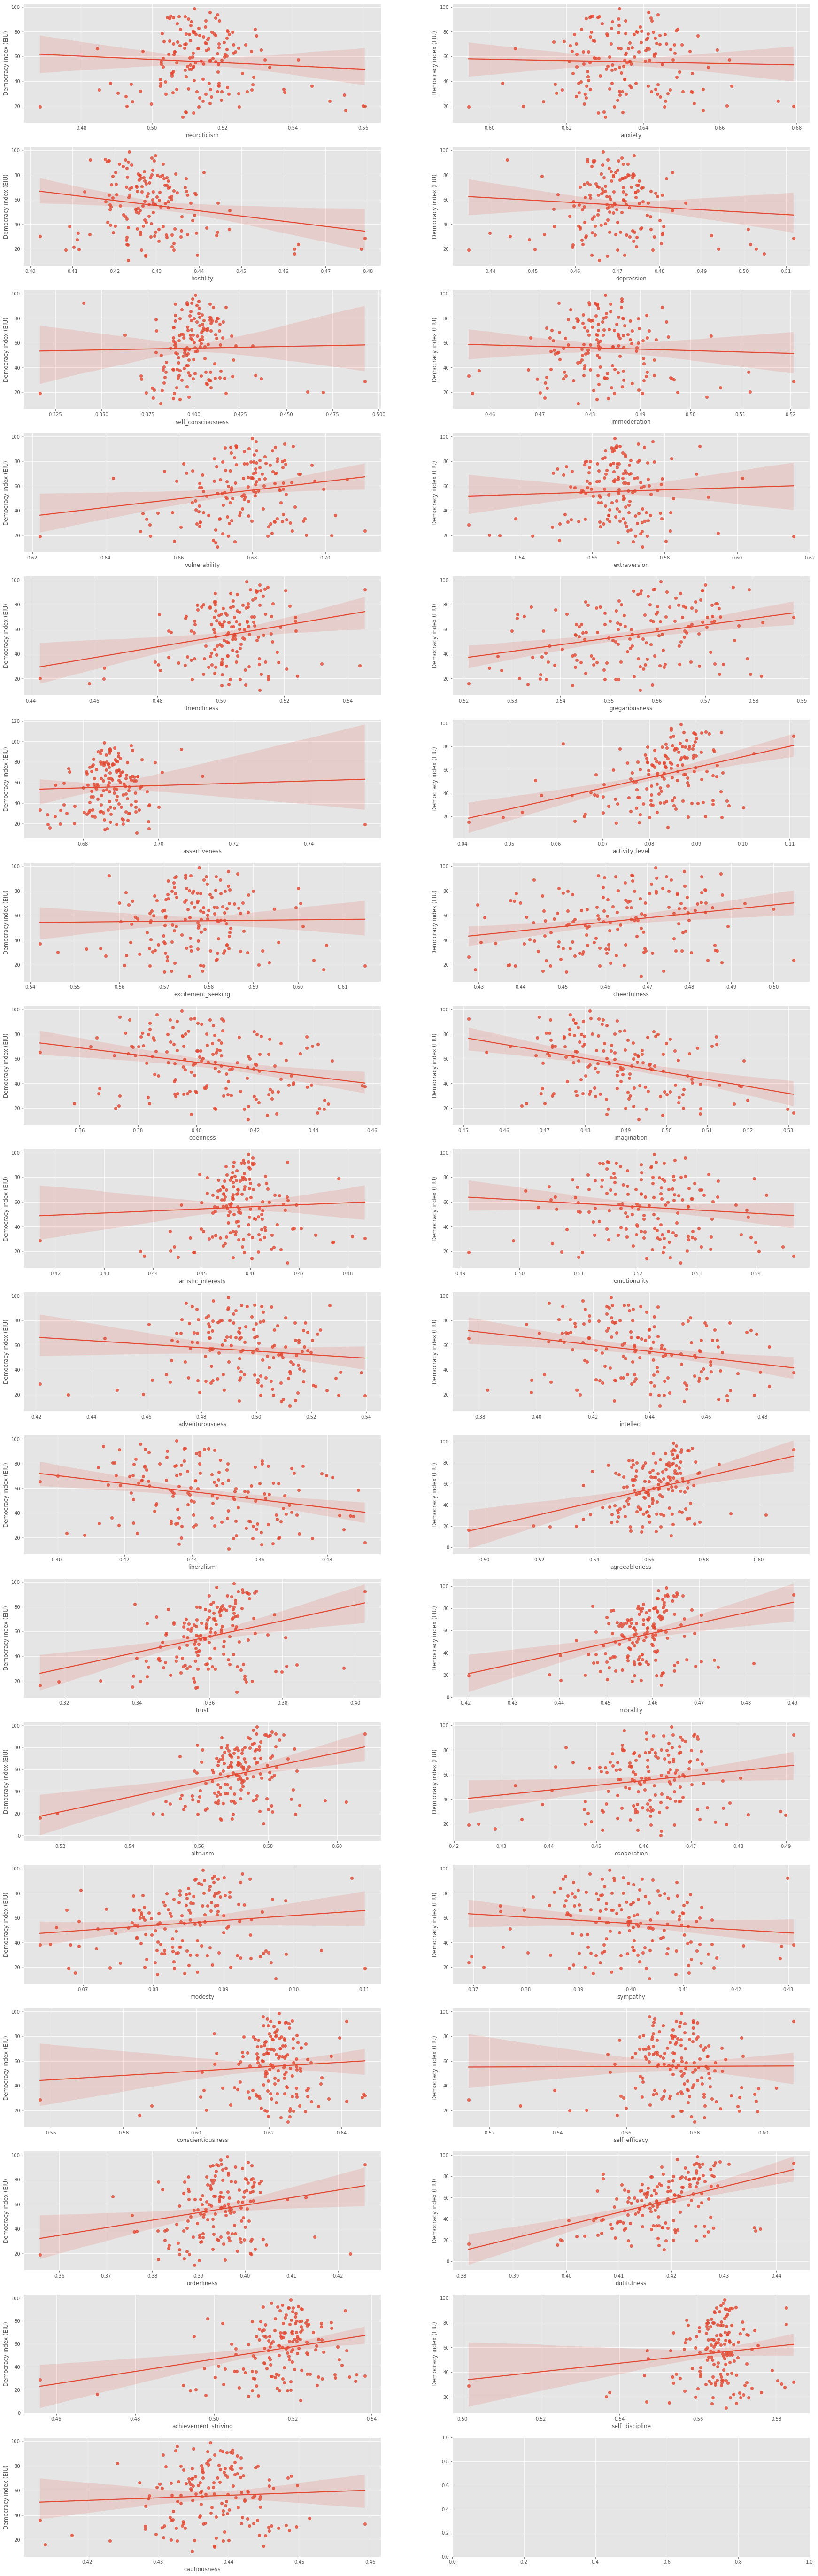

In [452]:
fig, axes = plt.subplots(18, 2, figsize=(30, 100))
for i, attr in enumerate(PERSONALITY_ATTRS):
    sns.regplot(data=country_personality_grouped_dem[country_personality_grouped_dem.year==2018], x=attr, y='Democracy index (EIU)', ax=axes[i//2, i%2])

Although most of the attributes are not significantly correlated, we can see some trend in *agreeableness*, *trust* and *dutifulness*. In our words, more democratic countries seem to be more agreeable, trustful and dutiful. 

Let's check the world happiness report next.

In [443]:
# Data was taken from https://worldhappiness.report/ed/2017/#appendices-and-data
whr2017 = pd.read_excel('data/online-data-chapter-2-whr-2017.xlsx', sheet_name="Figure2.2 WHR 2017")

In [453]:
whr2017.head()

,Country,Happiness score,Whisker-high,Whisker-low,Explained by: GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia (1.85) + residual
0,Norway,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [447]:
country_personality_whr2017 = country_personality_grouped[country_personality_grouped.year==2017].merge(whr2017, right_on='Country',
                                                                                                        left_on='country_name', how='inner')

In [454]:
country_personality_whr2017.head()

,year,country,num_speakers,speakers,neuroticism,anxiety,hostility,depression,self_consciousness,immoderation,...,Happiness score,Whisker-high,Whisker-low,Explained by: GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia (1.85) + residual
0,2017,Q1000,14,"Chris Silva,Mario Lemina,Jean Ping,Ali Bongo O...",0.519014,0.642868,0.432416,0.477602,0.398190,0.497252,...,4.465,4.557362,4.372639,1.198210,1.155620,0.356579,0.312329,0.043785,0.076047,1.322916
1,2017,Q1006,34,"Robert Sarah,Boubacar Keita,Amadou Diallo,Cell...",0.515417,0.643467,0.430833,0.463895,0.399759,0.480285,...,3.507,3.584428,3.429572,0.244550,0.791245,0.194129,0.348588,0.264815,0.110938,1.552312
2,2017,Q1009,73,"Joel Embiid,Pascal Siakam,Vera Songwe,Ben Mbal...",0.514569,0.634650,0.429287,0.464041,0.410228,0.486257,...,4.695,4.796541,4.593459,0.564305,0.946018,0.132892,0.430389,0.236298,0.051307,2.333646
3,2017,Q1013,9,"Lehlohonolo Seema,Tom Thabane,Pakalitha Mosisi...",0.512062,0.647234,0.425046,0.465177,0.379142,0.476410,...,3.808,4.044344,3.571656,0.521021,1.190095,0.000000,0.390661,0.157497,0.119095,1.429835
4,2017,Q1014,67,"Sam Johnson,George Weah,Ellen Johnson Sirleaf,...",0.510625,0.640196,0.426234,0.466537,0.393595,0.485018,...,3.533,3.653756,3.412244,0.119042,0.872118,0.229918,0.332881,0.266550,0.038948,1.673286


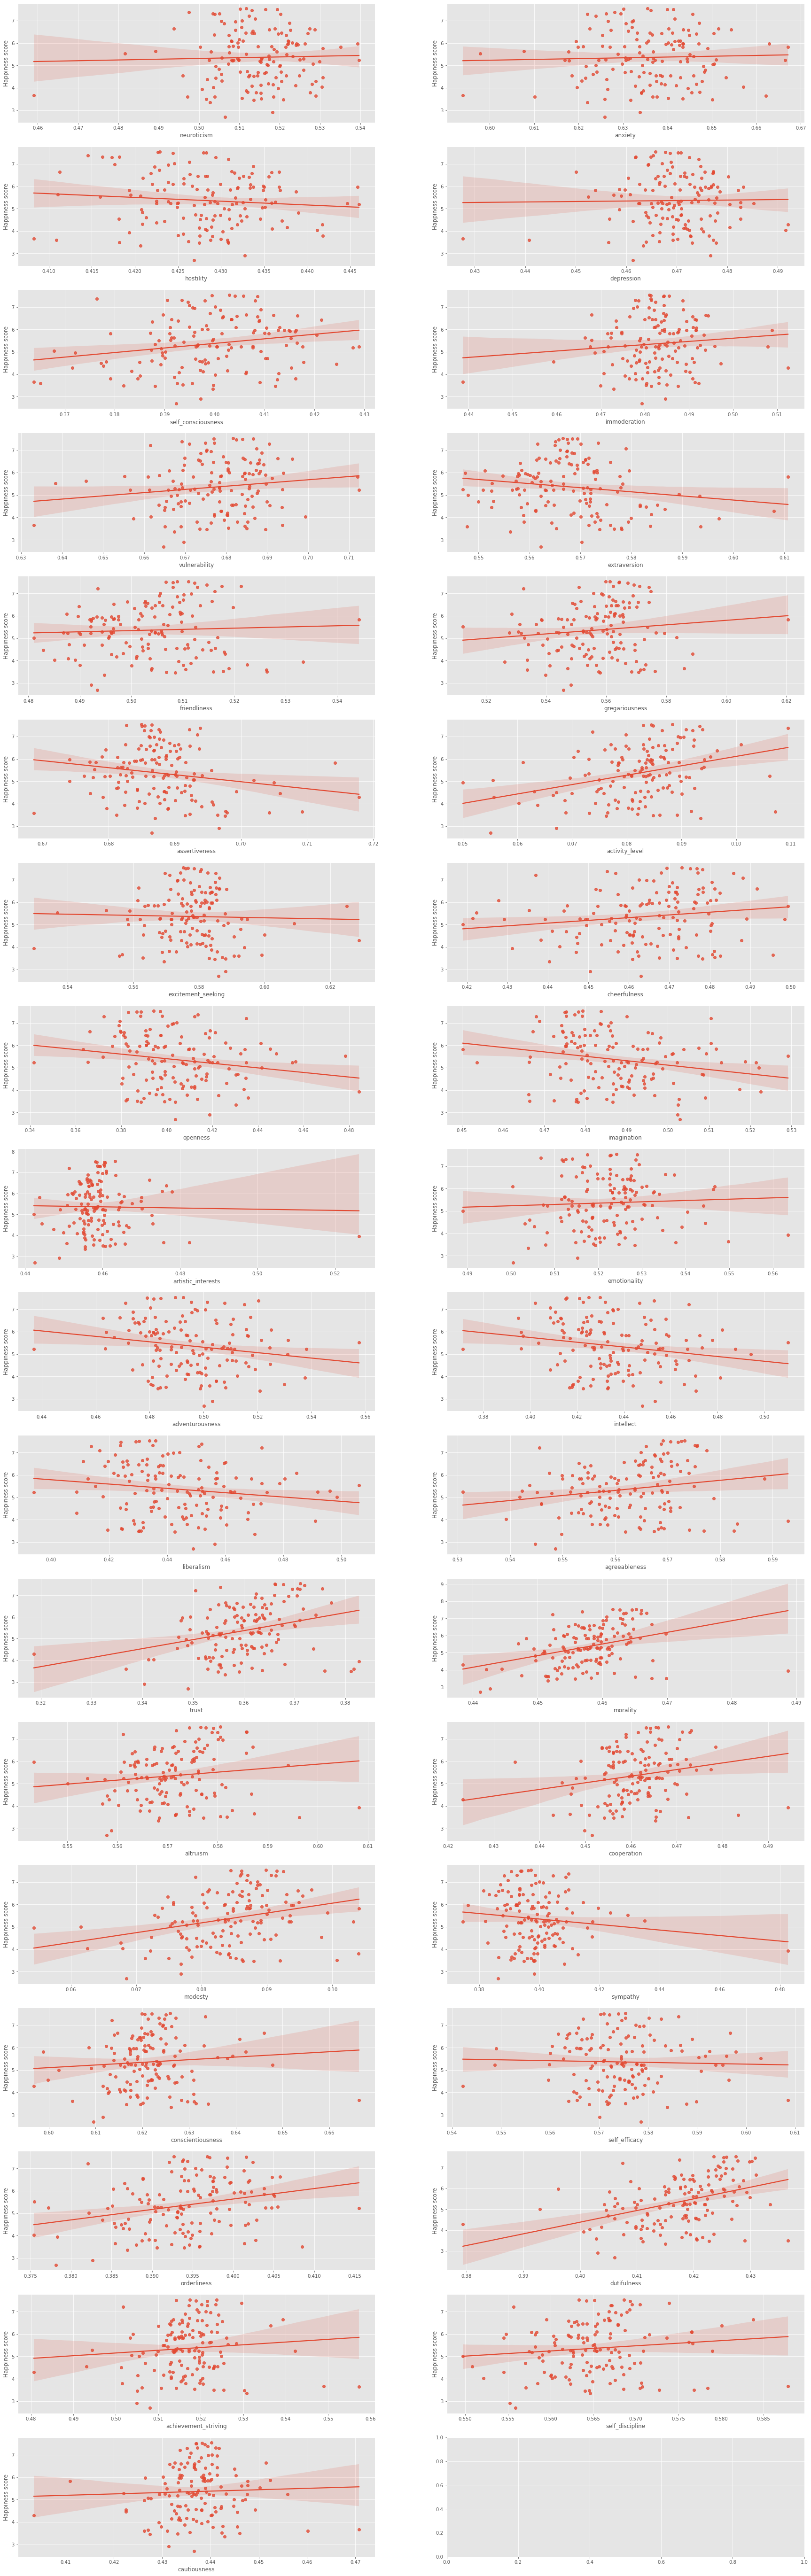

In [455]:
fig, axes = plt.subplots(18, 2, figsize=(30, 100))
for i, attr in enumerate(PERSONALITY_ATTRS):
    sns.regplot(data=country_personality_whr2017, x=attr, y='Happiness score', ax=axes[i//2, i%2])

We can again see some similar results here, but none seems to be significant enough.